# Assignment 2 2AMM10 2023-2024

## Group: [Shash_Kas_Pim]
### Member 1: [Shashank Prabhu]
### Member 2: [Kasra Gheytuli]
### Member 3: [Pim de Wildt]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [ ]:
!pip show torch

In [ ]:
# !pip install rdkit
# !pip install torch_geometric
# !pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

In [ ]:
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt

In [ ]:
dir_add = 'ass2_data/'

with open(dir_add+'pos_data.pkl', 'rb') as f:
    pos_data = pickle.load(f)

with open(dir_add+'type_data.pkl', 'rb') as f:
    type_data = pickle.load(f)

with open(dir_add+'smiles.pkl', 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load(dir_add+'data_split.npz')

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

formation_energy = np.load(dir_add+'formation_energy.npz')

fe = formation_energy['y'] # normalized formation energy
mu = formation_energy['mu']
std = formation_energy['sigma']

In [ ]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

In [ ]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

In [ ]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

In [ ]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

## Task 1

In [9]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.data import Data, DataLoader as GeometricDataLoader
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import Ridge

import numpy as np
import pickle
import time
import math
import os

from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
import rdkit.DataStructs as DataStructs
RDLogger.DisableLog('rdApp.*')

import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.auto import tqdm

### GNN

In [10]:
#GNN

class GNNMessagePassing(MessagePassing):
    """
    Message passing layer that updates node features by:
    h_i = UPDATE(old_h_i, mean(messages from neighbors))

    where:
    - message = EDGE_FUNC(h_i, h_j, edge_features)  
    - h_i = atom i's features
    - EDGE_FUNC = MLP processing atom pair + bond distance (implemented in 'message' function)
    
    (Ref lec 3)
    """
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super().__init__(aggr='mean') # Using mean aggregation for stability
        
        # Edge transfer function
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Node update function
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim)
        )
        
        self.layer_norm = nn.LayerNorm(node_dim)
        
    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)
    
    def message(self, x_i, x_j, edge_attr):
        edge_input = torch.cat([x_i, x_j, edge_attr], dim=-1)
        return self.edge_mlp(edge_input)
    
    def update(self, aggr_out, x):
        node_input = torch.cat([x, aggr_out], dim=-1)
        h = self.node_mlp(node_input)
        return self.layer_norm(h + x)  # Skip connection + norm


class MolecularGNN(nn.Module):
    """
    Complete GNN architecture for molecular property prediction.
    it respects molecular symmetries through distance based features
    """
    def __init__(self, num_atom_types=20, hidden_dim=128, num_layers=3):
        super().__init__()
        
        self.atom_embedding = nn.Embedding(num_atom_types, hidden_dim)
        self.input_projection = nn.Linear(hidden_dim + 3, hidden_dim)
        
        self.mp_layers = nn.ModuleList([
            GNNMessagePassing(hidden_dim, 1, hidden_dim)
            for _ in range(num_layers)
        ])
        
        self.output_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def compute_edge_features(self, pos, edge_index): 
        # For invariance - bond length remains invariant under rotation and translation invarance as ditance is invariant under translation
        """Compute rotation-invariant distance features"""
        row, col = edge_index
        distances = torch.norm(pos[row] - pos[col], dim=1, keepdim=True)
        return distances
    
    def forward(self, batch_data):
        x = batch_data.x
        pos = batch_data.pos
        edge_index = batch_data.edge_index
        batch = batch_data.batch
        
        # Embed atoms and combine with positions
        atom_features = self.atom_embedding(x)
        node_features = torch.cat([atom_features, pos], dim=-1)
        node_features = self.input_projection(node_features)
        
        # Compute edge features
        edge_features = self.compute_edge_features(pos, edge_index)
        
        # Message passing with skip connections
        for i, mp_layer in enumerate(self.mp_layers):
            if i > 0:
                node_features = node_features + mp_layer(node_features, edge_index, edge_features)
            else:
                node_features = mp_layer(node_features, edge_index, edge_features)
        
        # Global pooling
        graph_features = global_mean_pool(node_features, batch)
        
        return self.output_mlp(graph_features)

In [11]:
# Data pre proocessing (to add edges for a geometric representation)

def create_molecular_graph(positions, atom_types, threshold=2.5): #2.5 Angstroms is a common threshold for covalent bonds
    """
    Create PyTorch Geometric graph from molecular data - connects atoms within threshold distance (as they are 'floating' in space).
    """
    num_atoms = len(atom_types)
    positions = np.array(positions)
    
    # Create edges based on distance
    edges = []
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist < threshold:
                edges.append([i, j])
                edges.append([j, i])
    
    # Fallback: fully connected if no edges (not ideal for realism but ensures connectivity)
    if not edges:
        edges = [[i, j] for i in range(num_atoms) for j in range(num_atoms) if i != j]
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    return Data(
        x=torch.tensor(atom_types, dtype=torch.long),
        pos=torch.tensor(positions, dtype=torch.float),
        edge_index=edge_index
    )


#Dataset class and loaders

class GeometricDataset(Dataset):
    """PyTorch dataset for geometric molecular data"""
    def __init__(self, pos_data, type_data, targets, indices, threshold=2.5):
        self.graphs = []
        print(f"Creating {len(indices)} molecular graphs with threshold={threshold}...")
        for idx in tqdm(indices):
            graph = create_molecular_graph(pos_data[idx], type_data[idx], threshold)
            graph.y = torch.tensor([targets[idx]], dtype=torch.float)
            self.graphs.append(graph)
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return self.graphs[idx]


### SMILES

In [12]:
# SMILES PREPROCESSING AND TOKENIZATION

def build_char_vocab(smiles_list):
    """Build character-level vocabulary from SMILES strings"""
    chars = sorted({c for smi in smiles_list for c in smi})
    char2idx = {'<PAD>': 0, '<UNK>': 1}
    char2idx.update({c: i+2 for i, c in enumerate(chars)})
    idx2char = {idx: char for char, idx in char2idx.items()}
    return char2idx, idx2char

def tokenize_smiles(smi, char2idx, max_len):
    """Convert SMILES string to padded sequence of character indices"""
    indices = [char2idx.get(c, char2idx['<UNK>']) for c in smi]
    length = min(len(indices), max_len)
    
    # Pad or truncate to max_len
    if len(indices) < max_len:
        indices = indices + [char2idx['<PAD>']] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    
    return indices, length

def smiles_to_fp(smi, radius=2, nBits=2048):
    """Convert SMILES to Morgan fingerprint (for future use)"""
    arr = np.zeros((nBits,), dtype=np.uint8)
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        rdkit.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Build vocabulary from training data
train_smiles = [smiles_data[i] for i in train_idxes]
char2idx, idx2char = build_char_vocab(train_smiles)
vocab_size = len(char2idx)
max_len = max(len(smi) for smi in smiles_data)

print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {max_len}")
print(f"Sample characters: {list(char2idx.keys())[:20]}")

Vocabulary size: 26
Max sequence length: 62
Sample characters: ['<PAD>', '<UNK>', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '=', '@', 'C', 'F', 'H', 'N', 'O']


In [13]:
# LSTM MODEL FOR SMILES
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ImprovedLSTM(nn.Module):
    """
    LSTM-based model for SMILES sequence processing.
    Handles variable-length sequences with proper padding and packing.
    """
    def __init__(self, vocab_size, emb_dim=64, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        
        # Character embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False
        )
        
        # Regularization and output
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, seq, lengths=None):
        """
        Forward pass through LSTM
        Args:
            seq: (batch_size, seq_len) - tokenized SMILES
            lengths: (batch_size,) - actual lengths before padding
        """
        # Embed characters
        x = self.embedding(seq)  # (batch_size, seq_len, emb_dim)
        
        # Pack sequences for efficient LSTM processing
        if lengths is not None:
            x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)
        
        # LSTM forward pass
        lstm_out, (h_n, _) = self.lstm(x)
        
        if lengths is not None:
            lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        # Use final hidden state from last layer
        last_hidden = h_n[-1]  # (batch_size, hidden_dim)
        
        # Apply normalization and dropout
        out = self.layer_norm(last_hidden)
        out = self.dropout(out)
        
        return self.fc(out).squeeze(-1)

In [14]:
# SMILES DATASET CLASS
class SMILESDataset(Dataset):
    """PyTorch dataset for SMILES molecular data"""
    def __init__(self, smiles_data, targets, indices, char2idx, max_len):
        self.sequences = []
        self.lengths = []
        self.targets = []
        
        print(f"Processing {len(indices)} SMILES sequences...")
        for idx in tqdm(indices, desc="Tokenizing SMILES"):
            smi = smiles_data[idx]
            seq, length = tokenize_smiles(smi, char2idx, max_len)
            
            self.sequences.append(seq)
            self.lengths.append(length)
            self.targets.append(targets[idx])
        
        # Convert to tensors
        self.sequences = torch.tensor(self.sequences, dtype=torch.long)
        self.lengths = torch.tensor(self.lengths, dtype=torch.long) 
        self.targets = torch.tensor(self.targets, dtype=torch.float)
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx], self.targets[idx]

def smiles_collate_fn(batch):
    """Custom collate function for SMILES data - sorts by length for packing"""
    sequences, lengths, targets = zip(*batch)
    
    # Sort by length (descending) for efficient packing
    sorted_batch = sorted(zip(sequences, lengths, targets), 
                         key=lambda x: x[1], reverse=True)
    sequences, lengths, targets = zip(*sorted_batch)
    
    return (torch.stack(sequences), 
            torch.tensor(lengths), 
            torch.stack(targets))

### COMMON

In [15]:
# TRAINING AND EVALUATION FUNCTIONS

def train_epoch(model, loader, optimizer, criterion, device, model_type='gnn'):
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    
    desc = f"Training {model_type.upper()} batches"
    for batch in tqdm(loader, desc=desc, leave=False):
        if model_type == 'gnn':
            batch = batch.to(device)
            outputs = model(batch)
            targets = batch.y.view(-1, 1)
        else:  # SMILES
            sequences, lengths, targets = batch
            sequences = sequences.to(device)
            lengths = lengths.to(device)
            targets = targets.to(device).view(-1, 1)
            outputs = model(sequences, lengths=lengths).view(-1, 1)
        
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def evaluate(model, loader, criterion, device, model_type='gnn'):
    """Evaluate model on dataset and return metrics"""
    model.eval()
    total_loss = 0
    predictions = []
    targets_list = []
    
    with torch.no_grad():
        for batch in loader:
            if model_type == 'gnn':
                batch = batch.to(device)
                outputs = model(batch)
                targets = batch.y
            else: #SMILES
                sequences, lengths, targets = batch
                sequences = sequences.to(device)
                lengths = lengths.to(device)
                targets = targets.to(device)
                outputs = model(sequences, lengths=lengths)
            
            loss = criterion(outputs.view(-1), targets.view(-1))
            total_loss += loss.item()
            
            predictions.extend(outputs.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())
    
    predictions = np.array(predictions)
    targets_list = np.array(targets_list)
    
    # Calculate all metrics in (normalized))
    mae_norm = mean_absolute_error(targets_list, predictions)
    mse_norm = mean_squared_error(targets_list, predictions)
    r2 = r2_score(targets_list, predictions)
    
    # Unnormalize
    # For MAE and MSE: only multiply by std or std^2 respectively (mu cancels out in difference)
    mae_unnorm = mae_norm * std
    mse_unnorm = mse_norm * (std ** 2)
    

    return {
        'loss': total_loss / len(loader),
        'mae_norm': mae_norm,
        'mse_norm': mse_norm,
        'mae_unnorm': mae_unnorm,
        'mse_unnorm': mse_unnorm,
        'r2': r2,
        'predictions': predictions,
        'targets': targets_list
        }

#Helper
def generate_model_filename(config, model_type='gnn'):
    """Generate model filename based on hyperparameters and model type"""
    if model_type == 'gnn':
        return f"gnn_h{config['hidden_dim']}_l{config['num_layers']}_t{config['threshold']:.1f}_lr{config['lr']:.0e}_bs{config['batch_size']}_e{config['num_epochs']}.pt"
    else:  # SMILES
        return f"lstm_emb{config['emb_dim']}_h{config['hidden_dim']}_l{config['num_layers']}_lr{config['lr']:.0e}_bs{config['batch_size']}_e{config['num_epochs']}.pt"

In [16]:
def plot_results(results, config, model_type='gnn'):
    """Plot training/validation loss and true vs predicted scatter plot."""
    
    val_metrics = results['val_metrics']
    val_losses = [m['loss'] for m in val_metrics]
    test_results = results['test_results']
    
    
    # Pllot for loss curves
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Loss curves
    ax.plot(results['train_losses'], label='Train Loss', color='blue', linewidth=2)
    ax.plot(val_losses, label='Val Loss', color='orange', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('MSE Loss (normalized)', fontsize=12)
    ax.set_title(f'{model_type.upper()} Model - Training and Validation Loss', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    final_train_loss = results['train_losses'][-1]
    final_val_loss = val_losses[-1]
    
    ax.text(0.02, 0.98, f'Final Train Loss: {final_train_loss:.4f}\nFinal Val Loss: {final_val_loss:.4f}', 
            transform=ax.transAxes, verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Prediction scatter plot
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))

    # Unnormalized predictions
    targets_unnorm = test_results['targets'] * std + mu
    predictions_unnorm = test_results['predictions'] * std + mu
    
    ax1.scatter(targets_unnorm, predictions_unnorm, alpha=0.6, s=20)
    ax1.plot([targets_unnorm.min(), targets_unnorm.max()], 
             [targets_unnorm.min(), targets_unnorm.max()], 'r--', lw=2)
    ax1.set_xlabel('True Formation Energy (eV)')
    ax1.set_ylabel('Predicted Formation Energy (eV)')
    ax1.set_title(f'{model_type.upper()} Test Predictions (R² = {test_results["r2"]:.3f})')
    ax1.grid(True)
    
    plt.tight_layout()
    plt.show()

In [17]:
def run_training(config, model_type='gnn'):
    """Unified training function"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    np.random.seed(config['seed'])
    torch.manual_seed(config['seed'])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config['seed'])
    
    # Split training data for validation
    train_idx_split, val_idx_split = train_test_split(
        train_idxes, test_size=config['val_split'], random_state=config['seed']
    )
    
    print(f"\n{model_type.upper()} Data split:")
    print(f"Training: {len(train_idx_split)} molecules")
    print(f"Validation: {len(val_idx_split)} molecules")
    print(f"Test: {len(test_idxes)} molecules")

    print(f"TRAINING {model_type.upper()} MODEL")
    
    start = time.time()
    
    # Create datasets and loaders based on model type
    if model_type == 'gnn':
        train_dataset = GeometricDataset(pos_data, type_data, fe, train_idx_split, config['threshold'])
        val_dataset = GeometricDataset(pos_data, type_data, fe, val_idx_split, config['threshold'])
        test_dataset = GeometricDataset(pos_data, type_data, fe, test_idxes, config['threshold'])
        
        train_loader = GeometricDataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = GeometricDataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
        test_loader = GeometricDataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Initialize GNN model
        model = MolecularGNN(
            num_atom_types=20, 
            hidden_dim=config['hidden_dim'], 
            num_layers=config['num_layers']
        ).to(device)
        
    else:  # SMILES
        train_dataset = SMILESDataset(smiles_data, fe, train_idx_split, char2idx, max_len)
        val_dataset = SMILESDataset(smiles_data, fe, val_idx_split, char2idx, max_len)
        test_dataset = SMILESDataset(smiles_data, fe, test_idxes, char2idx, max_len)
        
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                                shuffle=True, collate_fn=smiles_collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                              shuffle=False, collate_fn=smiles_collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], 
                                shuffle=False, collate_fn=smiles_collate_fn)
        
        # Initialize LSTM model
        model = ImprovedLSTM(
            vocab_size=vocab_size,
            emb_dim=config['emb_dim'],
            hidden_dim=config['hidden_dim'], 
            num_layers=config['num_layers'],
            dropout=config['dropout']
        ).to(device)
    
    print(f"Data loading time: {time.time() - start:.2f} seconds")
    print(f"{model_type.upper()} Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Setup optimizer and scheduler
    weight_decay = config.get('weight_decay', 0)  # Default 0 for GNN, specified for SMILES
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config['scheduler_patience'], factor=config['scheduler_factor'])
    criterion = nn.MSELoss()

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_metrics = []
    
    start = time.time()
    for epoch in range(config['num_epochs']):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, model_type)
        
        # Validate
        val_results = evaluate(model, val_loader, criterion, device, model_type)
        
        # Store metrics
        train_losses.append(train_loss)
        val_metrics.append(val_results)
        
        # Learning rate scheduling
        scheduler.step(val_results['loss'])
        
        # Save best model
        if val_results['loss'] < best_val_loss:
            best_val_loss = val_results['loss']
            model_filename = generate_model_filename(config, model_type)
            torch.save(model.state_dict(), model_filename)
            print(f"Saved new best {model_type.upper()} model: {model_filename}")
        
        # Print progress
        print(f"Epoch {epoch+1}/{config['num_epochs']}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_results['loss']:.4f}")
        print(f"  Val MAE (norm): {val_results['mae_norm']:.4f}, (unnorm): {val_results['mae_unnorm']:.4f}")
        print(f"  Val MSE (norm): {val_results['mse_norm']:.4f}, (unnorm): {val_results['mse_unnorm']:.4f}")
        print(f"  Val R²: {val_results['r2']:.4f}")
        print(f"  Time elapsed: {time.time() - start:.2f} seconds")

    # Load best model and evaluate on test set
    model_filename = generate_model_filename(config, model_type)
    model.load_state_dict(torch.load(model_filename))
    test_results = evaluate(model, test_loader, criterion, device, model_type)
    

    print(f"FINAL {model_type.upper()} TEST RESULTS")
    print(f"NORMALIZED METRICS:")
    print(f"  Test MAE: {test_results['mae_norm']:.4f}")
    print(f"  Test MSE: {test_results['mse_norm']:.4f}")
    print(f"  Test R²:  {test_results['r2']:.4f}")
    print(f"\nUNNORMALIZED METRICS:")
    print(f"  Test MAE: {test_results['mae_unnorm']:.4f}")
    print(f"  Test MSE: {test_results['mse_unnorm']:.4f}")
    print(f"\nModel saved as: {model_filename}")
  
    
    return {
        'train_losses': train_losses,
        'val_metrics': val_metrics,
        'test_results': test_results,
        'model_filename': model_filename,
        'epochs_trained': len(train_losses)
    }

In [18]:
CONFIG_GNN = {
        # MODEL ARCHITECTURE
        'hidden_dim': 64,
        'num_layers': 3,
        'threshold': 2.5,         # Distance threshold in Angstroms
        
        # TRAINING PARAMETERS
        'lr': 1e-3,               
        'batch_size': 32,         
        'num_epochs': 2,         
        'scheduler_patience': 10,
        'scheduler_factor': 0.5,  
        
        # OTHER
        'seed': 69,               
        'val_split': 0.1,        #10%
    }
    
    
CONFIG_SMILES = {
    # MODEL ARCHITECTURE
    'emb_dim': 64,            
    'hidden_dim': 128,        
    'num_layers': 2,          
    'dropout': 0.1,           
    
    # TRAINING PARAMETERS
    'lr': 1e-3,               
    'weight_decay': 1e-5,     # L2 regularization
    'batch_size': 64,         
    'num_epochs': 2,         
    'scheduler_patience': 5,  
    'scheduler_factor': 0.5,  
    
    # OTHER
    'seed': 69,               
    'val_split': 0.1,
}

Using device: cuda

GNN Data split:
Training: 107110 molecules
Validation: 11902 molecules
Test: 10000 molecules
TRAINING GNN MODEL
Creating 107110 molecular graphs with threshold=2.5...


100%|██████████| 107110/107110 [01:56<00:00, 921.48it/s] 


Creating 11902 molecular graphs with threshold=2.5...


100%|██████████| 11902/11902 [00:12<00:00, 952.28it/s] 


Creating 10000 molecular graphs with threshold=2.5...


100%|██████████| 10000/10000 [00:09<00:00, 1046.95it/s]


Data loading time: 138.51 seconds
GNN Model parameters: 82,817


Saved new best GNN model: gnn_h64_l3_t2.5_lr1e-03_bs32_e2.pt
Epoch 1/2:
  Train Loss: 0.1499
  Val Loss: 0.0664
  Val MAE (norm): 0.1604, (unnorm): 1.6542
  Val MSE (norm): 0.0664, (unnorm): 7.0558
  Val R²: 0.9334
  Time elapsed: 70.77 seconds


Saved new best GNN model: gnn_h64_l3_t2.5_lr1e-03_bs32_e2.pt
Epoch 2/2:
  Train Loss: 0.0384
  Val Loss: 0.0412
  Val MAE (norm): 0.1589, (unnorm): 1.6385
  Val MSE (norm): 0.0412, (unnorm): 4.3825
  Val R²: 0.9586
  Time elapsed: 135.47 seconds
FINAL GNN TEST RESULTS
NORMALIZED METRICS:
  Test MAE: 0.1577
  Test MSE: 0.0411
  Test R²:  0.9592

UNNORMALIZED METRICS:
  Test MAE: 1.6259
  Test MSE: 4.3742

Model saved as: gnn_h64_l3_t2.5_lr1e-03_bs32_e2.pt
Model saved as: gnn_h64_l3_t2.5_lr1e-03_bs32_e2.pt


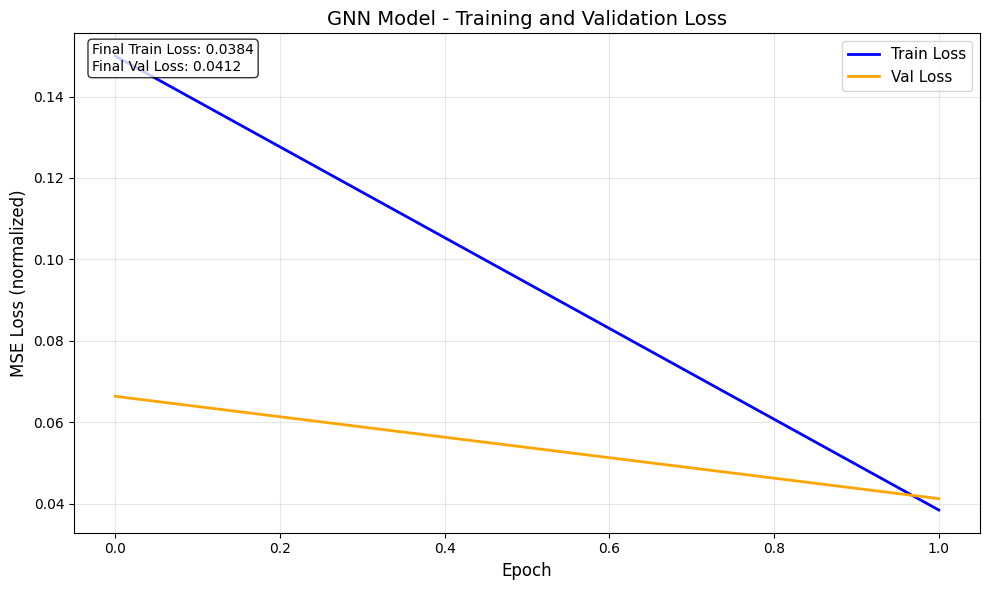

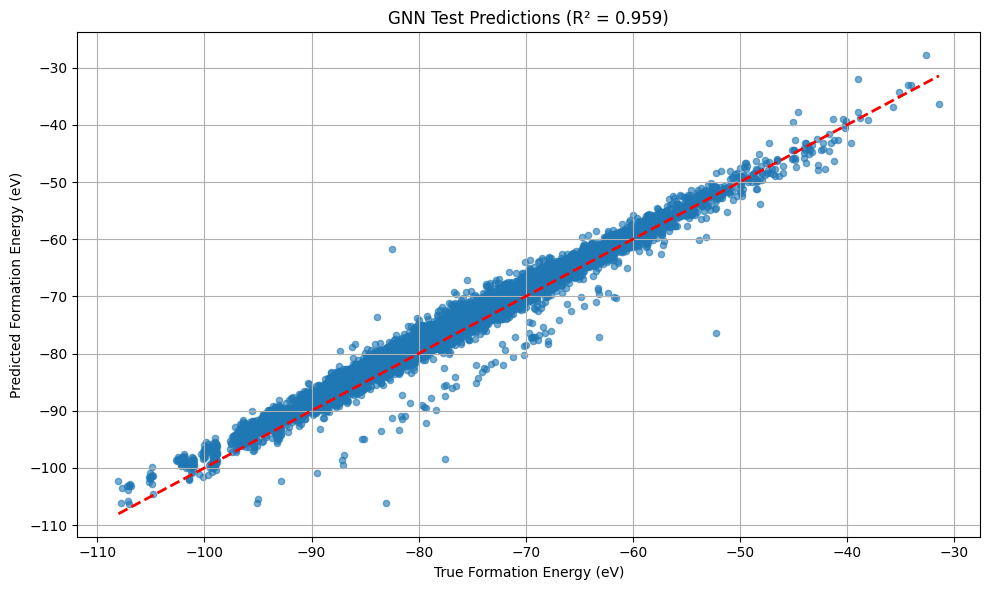

In [19]:
# Run training with the configuration
results_GNN = run_training(CONFIG_GNN, 'gnn')
print(f"Model saved as: {results_GNN['model_filename']}")

# Plot results
plot_results(results_GNN, CONFIG_GNN, 'gnn')

Using device: cuda

SMILES Data split:
Training: 107110 molecules
Validation: 11902 molecules
Test: 10000 molecules
TRAINING SMILES MODEL
Processing 107110 SMILES sequences...


Tokenizing SMILES: 100%|██████████| 107110/107110 [00:00<00:00, 263933.42it/s]


Processing 11902 SMILES sequences...


Tokenizing SMILES: 100%|██████████| 11902/11902 [00:00<00:00, 265969.46it/s]


Processing 10000 SMILES sequences...


Tokenizing SMILES: 100%|██████████| 10000/10000 [00:00<00:00, 277823.67it/s]


Data loading time: 0.98 seconds
SMILES Model parameters: 233,473


Saved new best SMILES model: lstm_emb64_h128_l2_lr1e-03_bs64_e2.pt
Epoch 1/2:
  Train Loss: 0.1280
  Val Loss: 0.0180
  Val MAE (norm): 0.0975, (unnorm): 1.0056
  Val MSE (norm): 0.0180, (unnorm): 1.9155
  Val R²: 0.9819
  Time elapsed: 38.34 seconds


Epoch 2/2:
  Train Loss: 0.0405
  Val Loss: 0.0269
  Val MAE (norm): 0.1390, (unnorm): 1.4329
  Val MSE (norm): 0.0269, (unnorm): 2.8621
  Val R²: 0.9730
  Time elapsed: 75.54 seconds
FINAL SMILES TEST RESULTS
NORMALIZED METRICS:
  Test MAE: 0.0966
  Test MSE: 0.0173
  Test R²:  0.9829

UNNORMALIZED METRICS:
  Test MAE: 0.9958
  Test MSE: 1.8361

Model saved as: lstm_emb64_h128_l2_lr1e-03_bs64_e2.pt
Model saved as: lstm_emb64_h128_l2_lr1e-03_bs64_e2.pt


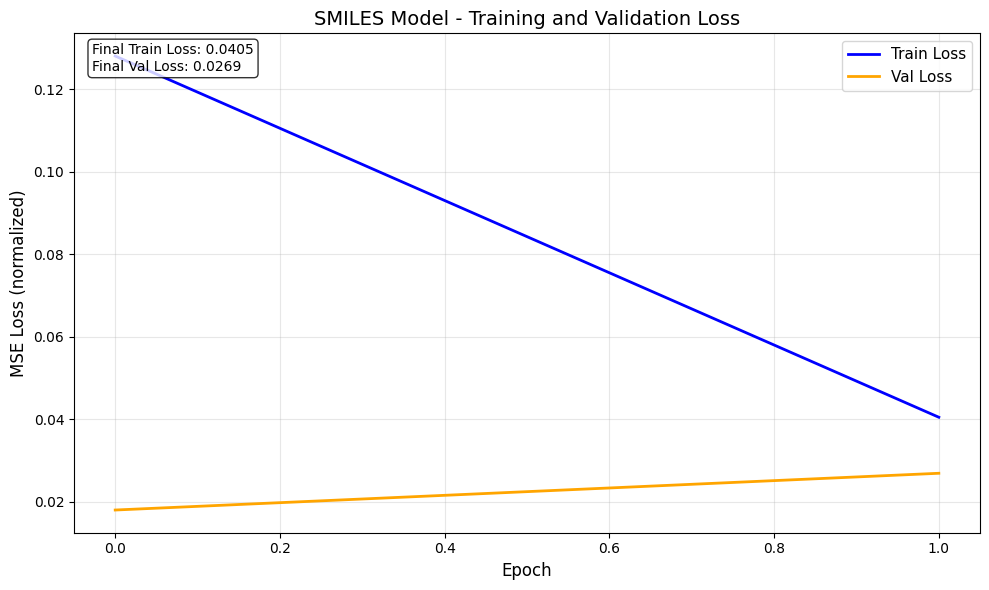

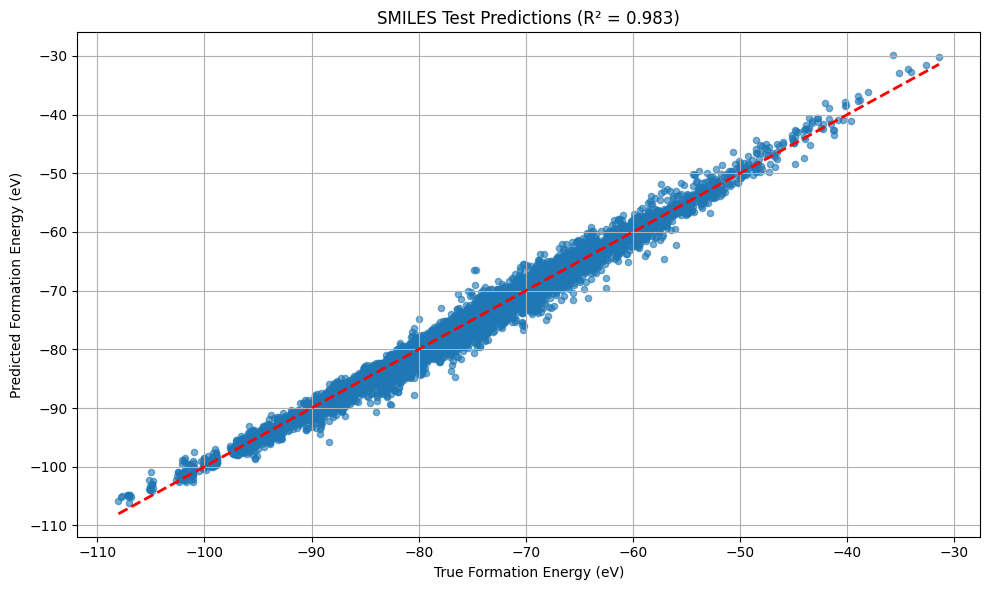

In [20]:
# Run training with the configuration
results_SMILES = run_training(CONFIG_SMILES, 'smiles')
print(f"Model saved as: {results_SMILES['model_filename']}")

# Plot results
plot_results(results_SMILES, CONFIG_SMILES, 'smiles')

## Task 2

## Task 3

In [21]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [22]:
canonicalize("COO"), canonicalize("O(C)O")

('COO', 'COO')

In [23]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(True, True, False)